### Import Requirements

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

#memory management
import gc

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#to impute missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

## Utility Functions
### Set folder paths for getting input and saving outputs

In [3]:
def setupFolderPaths():    
    #Set input data folder 
    dataFolder = os.getcwd() + os.sep + os.pardir + os.sep + 'ProjectDataFiles'
    if(not os.path.exists(dataFolder)):
        print("Input Data folder not found. Please specify data folder path as dataFolder variable to proceed")
        raise NotADirectoryError

    #Create output folder is it does not exist
    outputFolder = os.getcwd() + os.sep + os.pardir + os.sep + 'CodeOutputs'

    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
        print('Output Folder created')
        
    return dataFolder, outputFolder

In [4]:
def readFile(fileName):
    if(not os.path.exists(fileName)):
        raise FileNotFoundError
        
    return pd.read_csv(fileName)

## Check For Missing Values

In [5]:
# Function to calculate missing values by columns 
def compute_missing_values(df, sortAscending = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=sortAscending).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing value information
        return mis_val_table_ren_columns

In [6]:
#Functions used for plotting and visualizing outliers

# add noise to y axis to avoid overlapping of data points
def rand_jitter(arr):
    nosie = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr))

def plot_feature_distribution(df, column, fileName = ''):
    column_values = df[df[column].notna()][column]
    # group by target
    class_0_values = df[df[column].notna() & (df['TARGET']==0)][column]
    class_1_values = df[df[column].notna() & (df['TARGET']==1)][column]
    class_t_values = df[df[column].notna() & (df['TARGET'].isna())][column]        
    # for features with unique values >= 10
    if len(df[column].value_counts().keys()) >= 10:
        fig, ax = plt.subplots(1, figsize=(15, 4))
        if df[column].dtype == 'object':
            label_encoder = LabelEncoder()
            label_encoder.fit(column_values)
            class_0_values = label_encoder.transform(class_0_values)
            class_1_values = label_encoder.transform(class_1_values)
            class_t_values = label_encoder.transform(class_t_values)
            column_values = label_encoder.transform(column_values)
            plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, fontsize=12, rotation='vertical')

        ax.scatter(class_0_values, rand_jitter([0]*class_0_values.shape[0]), label='Class0', s=10, marker='o', color='#7ac143', alpha=1)
        ax.scatter(class_1_values, rand_jitter([10]*class_1_values.shape[0]), label='Class1', s=10, marker='o', color='#fd5c63', alpha=1)
        ax.scatter(class_t_values, rand_jitter([20]*class_t_values.shape[0]), label='Test', s=10, marker='o', color='#037ef3', alpha=0.4)
        ax.set_title(column +' group by target', fontsize=16)
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        ax.set_title(column +' distribution', fontsize=16)
    else:      
        all_categories = list(df[df[column].notna()][column].value_counts().keys())
        bar_width = 0.25
        
        fig, ax = plt.subplots(figsize=(20, 4))
        ax.set_title(column, fontsize=16)
        plt.xlabel('Categories', fontsize=16)
        plt.ylabel('Counts', fontsize=16)

        value_counts = class_0_values.value_counts()
        x_0 = np.arange(len(all_categories))
        y_0 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_0, y_0, color='#7ac143', width=bar_width, label='class0')

        value_counts = class_1_values.value_counts()
        x_1 = np.arange(len(all_categories))
        y_1 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_1+bar_width, y_1, color='#fd5c63', width=bar_width, label='class1')
        
        value_counts = class_t_values.value_counts()
        x_2 = np.arange(len(all_categories))
        y_2 = [value_counts.get(categroy, 0) for categroy in all_categories]
        ax.bar(x_2+2*bar_width, y_2, color='#037ef3', width=bar_width, label='test')
        
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        
        for i, v in enumerate(y_0):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i - .08, max(y_0)//1.25,  "{:0.1f}%".format(100*y_0[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
        
        for i, v in enumerate(y_1):
            if y_0[i]+y_1[i] == 0:
                ax.text(i - .08, max(y_0)//1.25,  'Missing in Train', fontsize=14, rotation='vertical')
            else:
                ax.text(i + bar_width - .08, max(y_0)//1.25, "{:0.1f}%".format(100*y_1[i]/(y_0[i]+y_1[i])), fontsize=14, rotation='vertical')
 
        for i, v in enumerate(y_2):
            if y_2[i] == 0:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, 'Missing in Test', fontsize=14, rotation='vertical')
            else:
                ax.text(i + 2*bar_width - .08, max(y_0)//1.25, str(y_2[i]), fontsize=14, rotation='vertical')
        
        plt.xticks(x_0 + 2*bar_width/3, all_categories, fontsize=16)
        
    plt.savefig(outputFolder + '\\{}{}_distribution.png'.format(column,fileName), bbox_inches='tight')
    plt.show()
    plt.close()

### Identify Feature types : Catagorical, Numerical, Integer and Boolean (Flags)

In [7]:
#Function to identify feature types in a given data frame
def identify_feature_types(df, features_to_ignore, verbose = False):
    categorical_features = list(f for f in df.select_dtypes(include='object') if f not in features_to_ignore)
    floatingPoint_features = list(f for f in df.select_dtypes(include='float64') if f not in features_to_ignore)
    temp = list(f for f in df.select_dtypes(include='int64') if f not in features_to_ignore)
    bool_features = [x for x in temp if 'FLAG' in x]
    integer_features = [x for x in temp if x not in bool_features]
    totalCount = len(categorical_features) + len(floatingPoint_features) + len(bool_features) + len(integer_features)
    if (verbose == True):
        print ('Catagorical Features : {}, Floating Point Features : {}, Boolean Features : {}, Integer Features : {}, Total Count : {}'
           .format(len(categorical_features), len(floatingPoint_features), len(bool_features), len(integer_features), totalCount))
    
    return categorical_features, floatingPoint_features, bool_features, integer_features

## Replace all the outliers in the input data set with nan

In [8]:
#Function to replace outliers in input data
def replace_outliers(df):
    #Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    if 'CODE_GENDER' in df:
        df = df[df['CODE_GENDER'] != 'XNA']

    #Replace outlier values with nan
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan)
    df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].map(lambda x: x if x >= 0 else np.nan)
    df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].map(lambda x: x if x <= 5e6 else np.nan)
    df['AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].map(lambda x: x if x <= 10 else np.nan)
    df['OBS_30_CNT_SOCIAL_CIRCLE'] = df['OBS_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 40 else np.nan)
    df['OBS_60_CNT_SOCIAL_CIRCLE'] = df['OBS_60_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 50 else np.nan)
    df['DEF_30_CNT_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 100 else np.nan)
    
    return df

### Setup input and output folders

In [9]:
dataFolder, outputFolder = setupFolderPaths()

# EDA:

In [10]:
#Read trining input file
input_df = readFile(dataFolder + '\\application_train.csv')
print(input_df.shape)
input_df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
input_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [12]:
feats_to_ignore = ['SK_ID_CURR', 'TARGET']
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df, feats_to_ignore, verbose=True)
print('\nCategorical Features:\n', categorical_feats)
print('\nBoolean Features:\n', bool_feats)
print('\nInteger Features:\n', integer_feats)
print('\nFloating Point Features:\n', floatingPoint_feats)

Catagorical Features : 16, Floating Point Features : 65, Boolean Features : 26, Integer Features : 13, Total Count : 120

Categorical Features:
 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

Boolean Features:
 ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

Integer F

In [13]:
input_df[categorical_feats].apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Check data imbalance

In [14]:
value_df = input_df['TARGET'].value_counts().to_frame().reset_index()
value_df.columns = ['Value', 'Count']
value_df['% of Total Values'] = [100 * value_df['Count'][0] / input_df.shape[0], 100 * value_df['Count'][1] / input_df.shape[0]]
value_df.head()

,Value,Count,% of Total Values
0,0,282686,91.927118
1,1,24825,8.072882


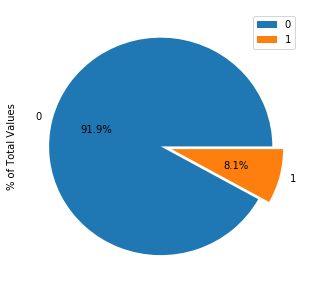

In [15]:
#Generate pie plot and save it in outputFolder
figure = value_df.plot.pie(y='% of Total Values', figsize= (5,5), explode=(0,0.1), autopct='%.1f%%').get_figure()

#### Save top and bottom 10 values in a csv. 

## Checking Missing Values

In [16]:
# Missing values statistics
missing_values = compute_missing_values(input_df)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


### Top 10 missing value features

In [17]:
missing_values.head(10)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### Bottom 10 missing value features

In [18]:
missing_values.tail(10)

,Missing Values,% of Total Values
NAME_TYPE_SUITE,1292,0.4
DEF_30_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.3
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_30_CNT_SOCIAL_CIRCLE,1021,0.3
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0
DAYS_LAST_PHONE_CHANGE,1,0.0


## Outliers detection and handling

In [19]:
#join train and test data sets for better visualization of outliers
training_df = readFile(dataFolder + '\\application_train.csv')
test_df = readFile(dataFolder + '\\application_test.csv')
combined_df = training_df.append(test_df)
print('Joined train rows {} with test rows {}. New total {}'.format(input_df.shape[0], test_df.shape[0],combined_df.shape[0]))

Joined train rows 307511 with test rows 48744. New total 356255


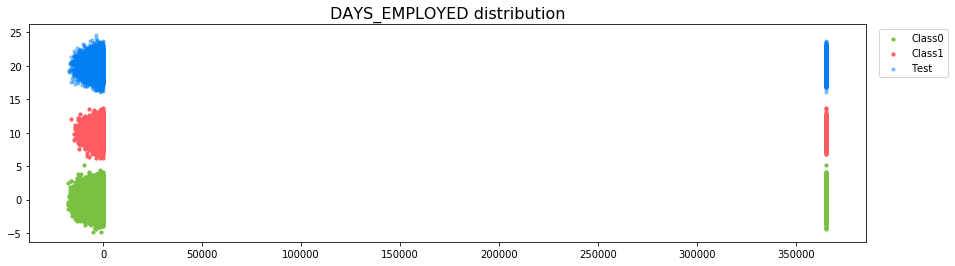

In [20]:
plot_feature_distribution(combined_df, 'DAYS_EMPLOYED')

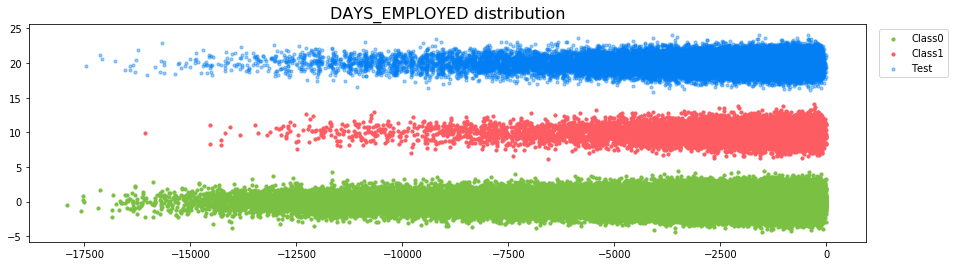

In [21]:
combined_df['DAYS_EMPLOYED'] = combined_df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan)
plot_feature_distribution(combined_df, 'DAYS_EMPLOYED', '_corrected')

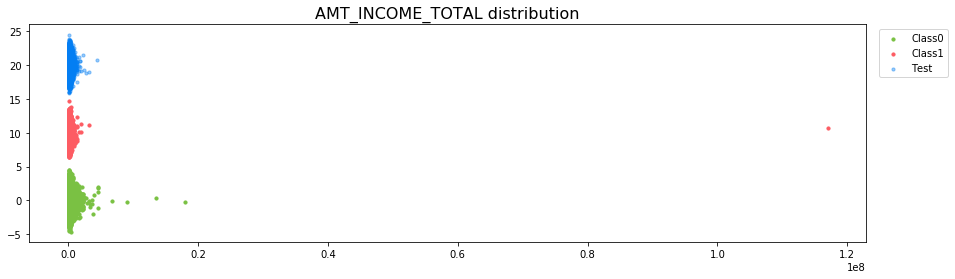

In [22]:
plot_feature_distribution(combined_df, 'AMT_INCOME_TOTAL')

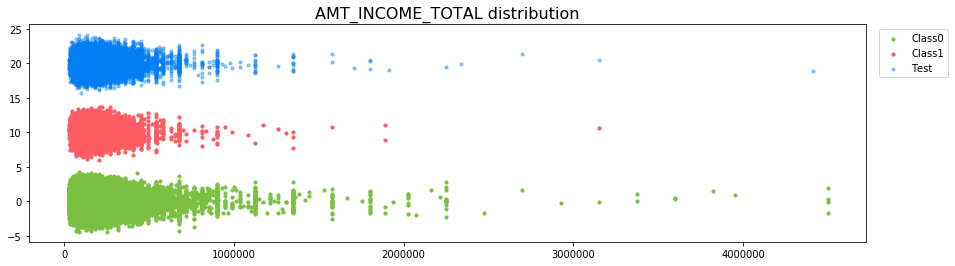

In [23]:
combined_df['AMT_INCOME_TOTAL'] = combined_df['AMT_INCOME_TOTAL'].map(lambda x: x if x <= 5e6 else np.nan)
plot_feature_distribution(combined_df, 'AMT_INCOME_TOTAL', '_corrected')

In [24]:
#Remove combined data frame to free up memory
del combined_df
gc.collect()

10782

### Feature Correlations

One way to try and understand the data is by looking for correlations between the features and the target. I can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”

In [25]:
input_df = replace_outliers(input_df)
# Find correlations with the target and sort
correlations = input_df.corr()['TARGET'].sort_values()
correlations = correlations.drop(index='TARGET')

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

strongest20 = pd.concat([correlations.head(10), correlations.tail(10)] , axis=0)

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031295
DEF_30_CNT_SOCIAL_CIRCLE       0.032261
LIVE_CITY_NOT_WORK_CITY        0.032517
OWN_CAR_AGE                    0.037611
DAYS_REGISTRATION              0.041976
FLAG_DOCUMENT_3                0.044341
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_WORK_CITY         0.050992
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_EMPLOYED                  0.074957
DAYS_BIRTH                     0.078242
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044009
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_MODE               -0.043231
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037225


### Feature Class-wise distribution
To visualize the effect of the age on the target, I will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). I will use the seaborn `kdeplot` for this graph.

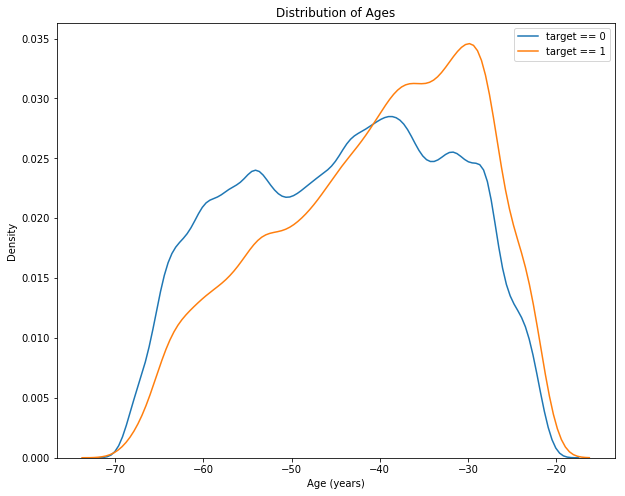

In [26]:
figure = plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(input_df.loc[input_df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(input_df.loc[input_df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

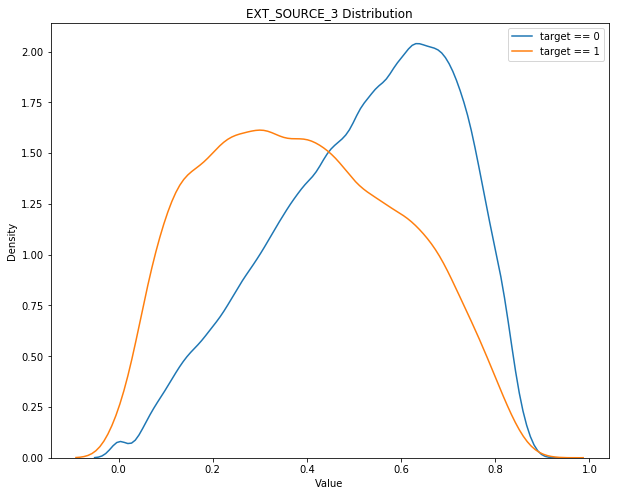

In [27]:
figure = plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(input_df.loc[input_df['TARGET'] == 0, 'EXT_SOURCE_3'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(input_df.loc[input_df['TARGET'] == 1, 'EXT_SOURCE_3'], label = 'target == 1')

# Labeling of plot
plt.xlabel('Value'); plt.ylabel('Density'); plt.title('EXT_SOURCE_3 Distribution');